# Build in collaboration with Misha Laskin, Chris Heinrich, and Evert P.L. van Nieuwenburg

In [20]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
print("PyTorch Version: ",torch.__version__)
import roofnet.utils.data as roof
import importlib
import copy
#print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0


In [8]:
#Helper function:
def make_data_array(data):
    out = []
    for l in range(len(data)//7):
        hold = {'img':[],'year':[],'meta':[]}
        for i in range(7):
            img, year, meta = data[l*7+i]
            hold['img'].append(img)
            hold['year'].append(year)
            hold['meta'].append(meta)
        out.append(hold)
    return out
        

In [9]:
data_dir = "C:\\Users\\Simas\\Desktop\\RoofNet"

In [10]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Size of latent space
latent_space = 128

# Batch size for training (change depending on how much memory you have)
batch_size = 3

# Number of epochs to train for
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

IMG_SHAPE = 224

# Follwoing the PyTorch guide to finetuning Torchvision Models

In [11]:
def run_model(model, dataloaders):
    score_hold = {'anchor':[],'pos':[],'neg':[]}

    model.eval()   # Set model to evaluate mode

    for x, y, meta in dataloaders:
        anchor = x[0].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)
        pos = x[1].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)
        neg = x[2].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)

      
        with torch.set_grad_enabled(False):
            anchor_output = model(anchor)
            pos_output = model(pos)
            neg_output = model(neg)

            score_hold['anchor'].append(anchor_output.detach().cpu().numpy())
            score_hold['pos'].append(pos_output.detach().cpu().numpy())
            score_hold['neg'].append(neg_output.detach().cpu().numpy())


    return score_hold

In [12]:
#This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. 
#By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. 
#However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Dropout(0.25),nn.Linear(num_ftrs, num_classes)) #Trying with dropout
    input_size = IMG_SHAPE

    return model_ft, input_size


In [14]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
#NAN Fixer
def batch_helper(x):
    b_size = int(len(x))
    anchor = x[list(range(0,b_size,3))]
    pos = x[list(range(1,b_size,3))]
    neg = x[list(range(2,b_size,3))]
    return anchor, pos, neg

def train_model_acc_noNAN(model, dataloaders_train, dataloaders_test, optimizer, margin = 0.0,  num_epochs=25, best_acc = 0.0):
    since = time.time()

    val_acc_history = []
    training_loss_history = []
    
    epoch_score = []
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = best_acc

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloaders = dataloaders_train
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = dataloaders_test

            running_loss = 0.0
            running_corrects = 0.0
            batches = 0.0
            score_hold = {'anchor':[],'pos':[],'neg':[]}

            # Iterate over data.
            for x, y, meta in dataloaders:
                x = batch_helper(x)
                anchor = x[0].to(device)
                pos = x[1].to(device)
                neg = x[2].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    anchor_output = model(anchor)
                    pos_output = model(pos)
                    neg_output = model(neg)
                    
                    #trying to fix NAN, bootleg fix that does the job
                    anchor_output[anchor_output!=anchor_output]=0
                    pos_output[pos_output!=pos_output] = 0
                    neg_output[neg_output!=neg_output] = 0
                    
                    
                    pos_term = torch.sqrt((anchor_output - pos_output).pow(2)).sum(1)
                    neg_term = torch.sqrt((anchor_output - neg_output).pow(2)).sum(1)

                    loss = torch.mean(F.relu(pos_term - neg_term + margin))
                   


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                acc = torch.mean(torch.stack([pos_term<neg_term]).double())
                running_corrects += acc
                batches += 1.0


            epoch_loss = running_loss / batches
            epoch_acc = running_corrects.double() / batches
            
            epoch_score.append(score_hold)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                training_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, training_loss_history, epoch_score

In [38]:
# Initialize the model for this run
model_ft, input_size = initialize_model(latent_space, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Params to learn:
	 fc.1.weight
	 fc.1.bias


# Run the model

In [31]:
importlib.reload(roof)

<module 'roofnet.utils.data' from 'C:\\Users\\Simas\\Desktop\\RoofNet\\roofnet\\utils\\data.py'>

In [42]:
data_file_path = data_dir + "\\train_hard.npy"
data = roof.ImageDataset(data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToPILImage(mode='RGB'),
                                transforms.ColorJitter(0.5,0.5,0.5,0),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
                    jitter=False)

val_data_file_path = data_dir + "\\test_easy.npy"
val_data = roof.ImageDataset(val_data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Try with normalization values, if nothing works remove
                            ]))

Loading data
Done loading data
Length 2765
Num Roofs 395
Loading data
Done loading data
Length 210
Num Roofs 30


In [43]:
BATCH_SIZE = 16
NUM_BATCHES = 200

VAL_BATCHES = 100

sampler = roof.TripletBuildingSampler(data,batch_size=BATCH_SIZE*NUM_BATCHES)
loader = torch.utils.data.DataLoader(data, sampler=sampler,batch_size=BATCH_SIZE*3)

val_sampler = roof.TripletBuildingSampler(val_data,batch_size=BATCH_SIZE*VAL_BATCHES)
val_loader = torch.utils.data.DataLoader(val_data, sampler=val_sampler,batch_size=BATCH_SIZE*3)

# Start with no margin and increase once network can match positive case

In [49]:
model_ft, hist, train_loss, score = train_model_acc_noNAN(model_ft, loader, val_loader, optimizer_ft, num_epochs=10, margin=0.0, best_acc = 0.831)

Epoch 0/9
----------
train Loss: 2.0089 Acc: 0.7444
val Loss: 1.5408 Acc: 0.8075

Epoch 1/9
----------
train Loss: 1.9638 Acc: 0.7300
val Loss: 1.3290 Acc: 0.8319

Epoch 2/9
----------
train Loss: 2.0241 Acc: 0.7303
val Loss: 1.3962 Acc: 0.8056

Epoch 3/9
----------
train Loss: 1.6939 Acc: 0.7431
val Loss: 1.3011 Acc: 0.8081

Epoch 4/9
----------
train Loss: 1.8289 Acc: 0.7137
val Loss: 1.2706 Acc: 0.8075

Epoch 5/9
----------
train Loss: 1.7046 Acc: 0.7369
val Loss: 1.3654 Acc: 0.8063

Epoch 6/9
----------
train Loss: 1.8458 Acc: 0.7169
val Loss: 1.4167 Acc: 0.7719

Epoch 7/9
----------
train Loss: 1.7017 Acc: 0.7253
val Loss: 1.5309 Acc: 0.7825

Epoch 8/9
----------
train Loss: 1.8334 Acc: 0.7166
val Loss: 1.4299 Acc: 0.7906

Epoch 9/9
----------
train Loss: 1.8282 Acc: 0.7053
val Loss: 1.3402 Acc: 0.8000

Training complete in 37m 8s
Best val Acc: 0.831875


In [48]:
model_ft, hist, train_loss, score = train_model_acc_noNAN(model_ft, loader, val_loader, optimizer_ft, num_epochs=10, margin=5.0, best_acc = 0.831)

Epoch 0/9
----------
train Loss: 3.8062 Acc: 0.7362
val Loss: 2.4962 Acc: 0.8106

Epoch 1/9
----------
train Loss: 3.7333 Acc: 0.7356
val Loss: 2.5166 Acc: 0.8250

Epoch 2/9
----------
train Loss: 3.9984 Acc: 0.7059
val Loss: 2.5148 Acc: 0.8087

Epoch 3/9
----------
train Loss: 3.7787 Acc: 0.7253
val Loss: 2.6039 Acc: 0.8113

Epoch 4/9
----------
train Loss: 3.6737 Acc: 0.7384
val Loss: 2.8071 Acc: 0.7875

Epoch 5/9
----------
train Loss: 3.9405 Acc: 0.7188
val Loss: 2.8379 Acc: 0.7931

Epoch 6/9
----------
train Loss: 3.5008 Acc: 0.7416
val Loss: 2.5849 Acc: 0.8137

Epoch 7/9
----------
train Loss: 3.6983 Acc: 0.7278
val Loss: 2.2825 Acc: 0.8244

Epoch 8/9
----------
train Loss: 3.4252 Acc: 0.7419
val Loss: 2.9498 Acc: 0.7812

Epoch 9/9
----------
train Loss: 3.6542 Acc: 0.7341
val Loss: 2.6408 Acc: 0.8025

Training complete in 36m 39s
Best val Acc: 0.831000


In [50]:
torch.save(model_ft.state_dict(),'Hard Train 0_5_10 Margin Easy Val Dropout Jitter')

# Evaluate the latent vectors

In [52]:
def get_metrics(model, data, anchor_index=0):
    #Returns distance to anchor, magnitude of latent vector, and distance to neighbor
    #Input is normalized PyTorch vector, same parameters as in training

    model.eval()   # Set model to evaluate mode
    
    anchor = data['img'][anchor_index].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)
    anchor_output = model(anchor)
    anchor_value = anchor_output.detach().cpu().numpy()
    anchor_value[anchor_value != anchor_value] = 0
    
    compare_to_anchor = []
    magnitude = []
    compare_to_next = []
    
    
    temp =  model(data['img'][0].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)).detach().cpu().numpy()
    temp[temp != temp] = 0
    
    
    for i in range(len(data['img'])):
        compare = data['img'][i].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)
        compare_output = model(compare)
        compare_value = compare_output.detach().cpu().numpy()
        compare_value[compare_value!=compare_value] = 0
         
        compare_to_anchor.append(np.sqrt(np.sum(np.square(anchor_value-compare_value))))
        magnitude.append(np.sqrt(np.sum(np.square(compare_value))))
        compare_to_next.append(np.sqrt(np.sum(np.square(temp-compare_value))))
        
        temp = compare_value

    return compare_to_anchor, magnitude, compare_to_next

# Vizualize various comparison techniques on trained data

In [63]:
dataset = np.load(data_file_path,allow_pickle=True)
dataset = dataset.item().get('data')

In [54]:
solo_sampler = roof.TripletBuildingSampler(data,batch_size=1)
solo_loader = torch.utils.data.DataLoader(data, sampler=solo_sampler,batch_size=3)
sorted_data = make_data_array(data)

In [76]:
n += 1

In [77]:
comp_a, mag, comp_n = get_metrics(model_ft,sorted_data[n],anchor_index=0)
print('Compare to anchor: ',comp_a, 'Pred year: ',comp_a.index(max(comp_a))+2012)
print('Magnitude: ',mag,'Pred year: ',mag.index(max(mag))+2012)
print('Compare to next: ', comp_n,'Pred year: ',comp_n.index(max(comp_n))+2012)

Compare to anchor:  [0.0, 4.93683, 5.066277, 5.1893587, 3.5331302, 5.3639765, 8.611157] Pred year:  2018
Magnitude:  [5.8067837, 5.9839897, 5.996622, 6.1915565, 6.0707374, 6.182961, 8.399903] Pred year:  2018
Compare to next:  [0.0, 4.93683, 5.04749, 5.0922456, 5.2990136, 5.197323, 8.242725] Pred year:  2018


In [78]:
print(sorted_data[n]['meta'][0]['transition_year'])

2018


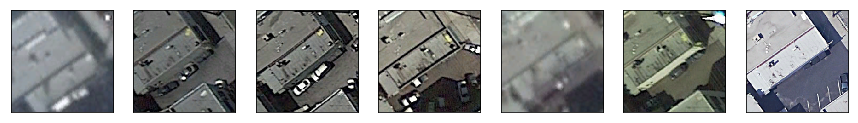

In [79]:
imgs = dataset[sorted_data[n]['meta'][0]['address']]['imgs']
f, axs = plt.subplots(1,7,figsize=(15,5))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
plt.show(f)

In [84]:
#Run comparisons over entire data stream, a set with no threshold and dumb maximum check, 
#second set with threshold and moving anchor

def get_accuracy_over_data(model,data,threshold=0.16,abs_mag=False,anchor_index=0):

    simple_pred = []
    simple_pred_acc = []

    time_pred = []
    time_pred_acc = []
    
    pred_year = []
    
    address = []

    for i in data:
        comp_a, mag, comp_n = get_metrics(model,i,anchor_index)
        trans_year = i['meta'][0]['transition_year']
        pred_year.append(trans_year)
        address.append(i['meta'][0]['address'])

        #simple predictors:
        comp_a_pred = comp_a.index(max(comp_a))+2012
        mag_pred = mag.index(max(mag))+2012
        comp_n_pred = comp_n.index(max(comp_n))+2012

        simple_pred.append(np.array([comp_a_pred,mag_pred,comp_n_pred]))
        simple_pred_acc.append(np.array([abs(comp_a_pred-trans_year),abs(mag_pred-trans_year),abs(comp_n_pred-trans_year)]))

        #Predictors sensative to time series data:
        time_pred_hold = []
        time_pred_acc_hold = []

        for j in range(anchor_index+2,len(comp_a)):
            if comp_a[j] > comp_a[anchor_index+1]*(1 + threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(comp_a)-1:
                time_pred_hold.append(2012+anchor_index+1)
                time_pred_acc_hold.append(abs(2012+anchor_index+1-trans_year))

        for j in range(0,len(mag)):
            if abs_mag:
                delta_mag = np.abs(mag[j]-mag[anchor_index])
            else:
                delta_mag = mag[j]-mag[anchor_index]
            if delta_mag > mag[anchor_index]*(threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(mag)-1:
                time_pred_hold.append(2012)
                time_pred_acc_hold.append(abs(2012-trans_year))

        for j in range(1,len(comp_n)):
            if comp_n[j] > comp_n[anchor_index+1]*(1 + threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(comp_n)-1:
                time_pred_hold.append(2012)
                time_pred_acc_hold.append(abs(2012-trans_year))

        time_pred.append(np.array(time_pred_hold))
        time_pred_acc.append(np.array(time_pred_acc_hold))
    
    pred_year = np.array(pred_year)
    
    simple_pred = np.array(simple_pred)
    simple_pred_acc = np.array(simple_pred_acc)

    time_pred = np.array(time_pred)
    time_pred_acc = np.array(time_pred_acc)
    
    address = np.array(address)
    
    return simple_pred, simple_pred_acc, time_pred, time_pred_acc, pred_year, address


# Test various anchors

In [133]:
simple_pred, simple_pred_acc, time_pred, time_pred_acc,pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25)
np.mean(simple_pred,0)

In [134]:
simple_pred_1, simple_pred_acc_1, time_pred_1, time_pred_acc_1, pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25,anchor_index=1)
np.mean(simple_pred_1,0)

In [135]:
simple_pred_2, simple_pred_acc_2, time_pred_2, time_pred_acc_2, pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25,anchor_index=2)
np.mean(simple_pred_2,0)

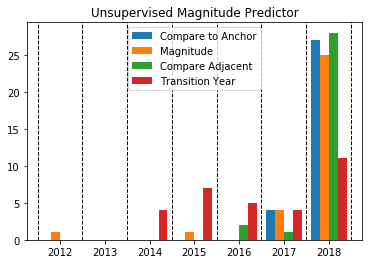

In [147]:
plt.hist(np.hstack((simple_pred,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

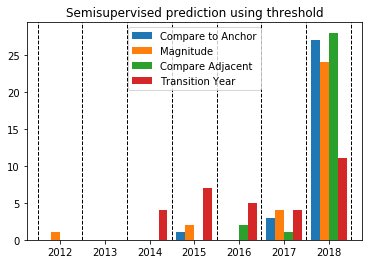

In [95]:
plt.hist(np.hstack((simple_pred_1,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

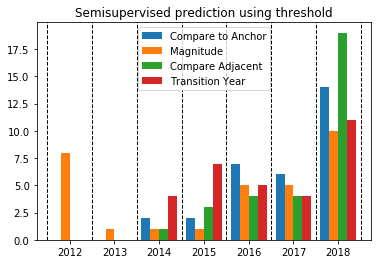

In [128]:
plt.hist(np.hstack((time_pred,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

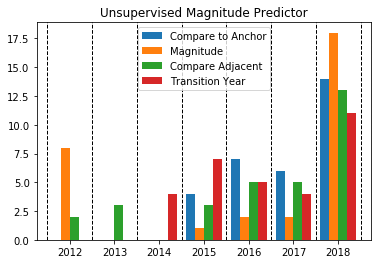

In [127]:
plt.hist(np.hstack((time_pred_1,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

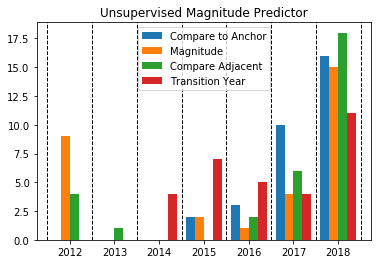

In [123]:
plt.hist(np.hstack((time_pred_2,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

# Testing accuracy of different anchors and techniques to use on test data

In [136]:
np.mean(time_pred_acc,0)

array([0.61290323, 2.5483871 , 0.67741935])

In [137]:
np.mean(time_pred_acc_1,0)

array([0.70967742, 1.93548387, 1.06451613])

In [138]:
np.mean(time_pred_acc_2,0)

array([0.80645161, 1.77419355, 1.32258065])

# Test Data, evaluate with anchor 0 and comparison to anchor

In [351]:
#Normal data set of images and meta data before being passed into PyTorch tensors
val_dir = "\\easy_test_"+str(IMG_SHAPE)+".npy"
valdata = np.load(data_dir + val_dir,allow_pickle=True)
valdata = valdata.item().get('data')

In [352]:
val_data_file_path = data_dir + val_dir
val_data = roof.ImageDataset(val_data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Try with normalization values, if nothing works remove
                            ]))
val_solo_sampler = roof.TripletBuildingSampler(val_data,batch_size=1)
val_solo_loader = torch.utils.data.DataLoader(val_data, sampler=val_solo_sampler,batch_size=3)
sorted_val = make_data_array(val_data)

Loading data
Done loading data
Length 210
Num Roofs 30


In [464]:
simple_pred_v_0, simple_pred_acc_v_0, time_pred_v_0, time_pred_acc_v_0, pred_year_v, address_v = get_accuracy_over_data(model_ft,sorted_val,threshold=0.10,anchor_index=0)
np.mean(time_pred_acc_v_0,0)

array([1.8       , 2.06666667, 1.9       ])

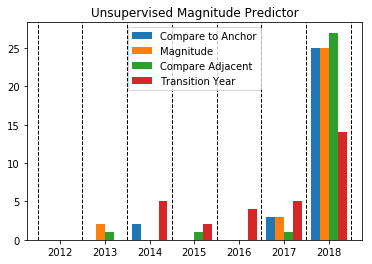

In [428]:
plt.hist(np.hstack((simple_pred_v_0,pred_year_v.reshape(len(pred_year_v),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

In [ ]:
plt.hist(np.hstack((time_pred_v_0,pred_year_v.reshape(len(pred_year_v),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

In [447]:
out = {'site_address': address_v, 'transition_true': pred_year_v, 'transition_predicted': time_pred_v_0[:,0]}

In [205]:
import pandas as pd

# Output results on test data for paper

In [448]:
pd.DataFrame(out).to_csv('Easy Train Easy Val.csv')